<a href="https://colab.research.google.com/github/123nishant/Google-Colab/blob/master/Recommendation_Systems_using_NETWORKX_knowledge_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14, 14]

In [14]:
df = pd.read_csv('/content/netflix_titles.csv')

df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day

# Convert columns "director, listed_in, cast and country" in columns that contain a real list
# The strip function is applied on elements
# if the value is NaN. the new column contains a empty list[]

df['directors'] = df['director'].apply(lambda l:[] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019.0,9.0,9.0,"[Richard Finn, Tim Maltby]","[Children & Family Movies, Comedies]","[Alan Marriott, Andrew Toth, Brian Dobson, Col...","[United States, India, South Korea, China]"
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016.0,9.0,9.0,[],[Stand-Up Comedy],[Jandino Asporaat],[United Kingdom]
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018.0,9.0,8.0,[],[Kids' TV],"[Peter Cullen, Sumalee Montano, Frank Welker, ...",[United States]
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2018.0,9.0,8.0,[],[Kids' TV],"[Will Friedle, Darren Criss, Constance Zimmer,...",[United States]
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,2017.0,9.0,8.0,[Fernando Lebrija],[Comedies],"[Nesta Cooper, Kate Walsh, John Michael Higgin...",[United States]


In [15]:
print(df.shape)

(6234, 19)


# KMeans Clustering with TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df = 0.4, # Drop words that occur i more than x percent of documents
                         min_df = 1, # Only use words that appear at least X times
                         stop_words = 'english', # Remove stop words
                         lowercase = True, # Convert to lower case
                         use_idf = True, # Use idf : Inverse Document Frequency
                         norm = u'l2', # Normalize
                         smooth_idf = True # Prevents divide-by-zero errors
                         )

tfidf = vector.fit_transform(text_content)

Clustering Kmeans

In [17]:
k = 200 # Taken at random maybe
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]

terms = vector.get_feature_names()

# Print center of clusters

for i in range(0, k):
  word_list = []
  print("cluster%d:"%i)

  for j in centers[i, :10]:
    word_list.append(terms[j])
  print(word_list)

cluster0:
['pazsitzky', 'biting', 'christina', 'dose', 'seattle', 'horrors', 'telling', 'giving', 'birth', 'truths']
cluster1:
['montserrat', 'aguazul', 'tangle', 'wily', 'seaside', 'gangsters', 'financial', 'ruin', 'obsession', 'lovers']
cluster2:
['lavagirl', 'sharkboy', 'baddie', 'producing', 'dreamer', 'mighty', 'imaginary', 'nefarious', 'battling', 'seek']
cluster3:
['suits', 'mascot', 'christopher', 'romp', 'furry', 'offbeat', 'guest', 'contestants', 'vie', 'title']
cluster4:
['fillmore', 'auditorium', 'musings', 'burr', 'let', 'loose', 'francisco', 'historic', 'filmed', 'san']
cluster5:
['assignment', 'murderous', 'homicide', 'diary', 'recovers', 'reserved', 'freshman', 'acts', 'clues', 'tough']
cluster6:
['shepherd', 'canine', 'bolt', 'shipped', 'mistakenly', 'trek', 'german', 'cross', 'hollywood', 'actor']
cluster7:
['confirmation', 'lara', 'hurdles', 'surgery', 'ballet', 'prepares', 'gender', 'physical', 'emotional', 'dancer']
cluster8:
['pennsylvania', 'hemlock', 'plain', 'e

In [18]:
request_transform = vector.transform(df['description'])
# New column cluster based on the description

df['cluster'] = kmeans.predict(request_transform)

df['cluster'].value_counts().head()

44    5938
97      11
15       8
32       5
49       5
Name: cluster, dtype: int64

In [19]:
df['cluster'].value_counts()

44    5938
97      11
15       8
32       5
49       5
      ... 
82       1
78       1
74       1
70       1
0        1
Name: cluster, Length: 198, dtype: int64

In [20]:
def find_similar(tfidf_matrix, index, top_n = 5):

  cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
  related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i!= index]

  return [index for index in related_docs_indices][0:top_n]

In [39]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))        

 iter 0 -- 0.033312320709228516 seconds --
 iter 1000 -- 4.980225563049316 seconds --
 iter 2000 -- 9.91504716873169 seconds --
 iter 3000 -- 14.826107263565063 seconds --
 iter 4000 -- 19.77293610572815 seconds --
 iter 5000 -- 24.67874026298523 seconds --
 iter 6000 -- 29.57528018951416 seconds --
 finish -- 30.862313508987427 seconds --


What's going on ? 

Creating a subgraph with only 2 movies

In [40]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()



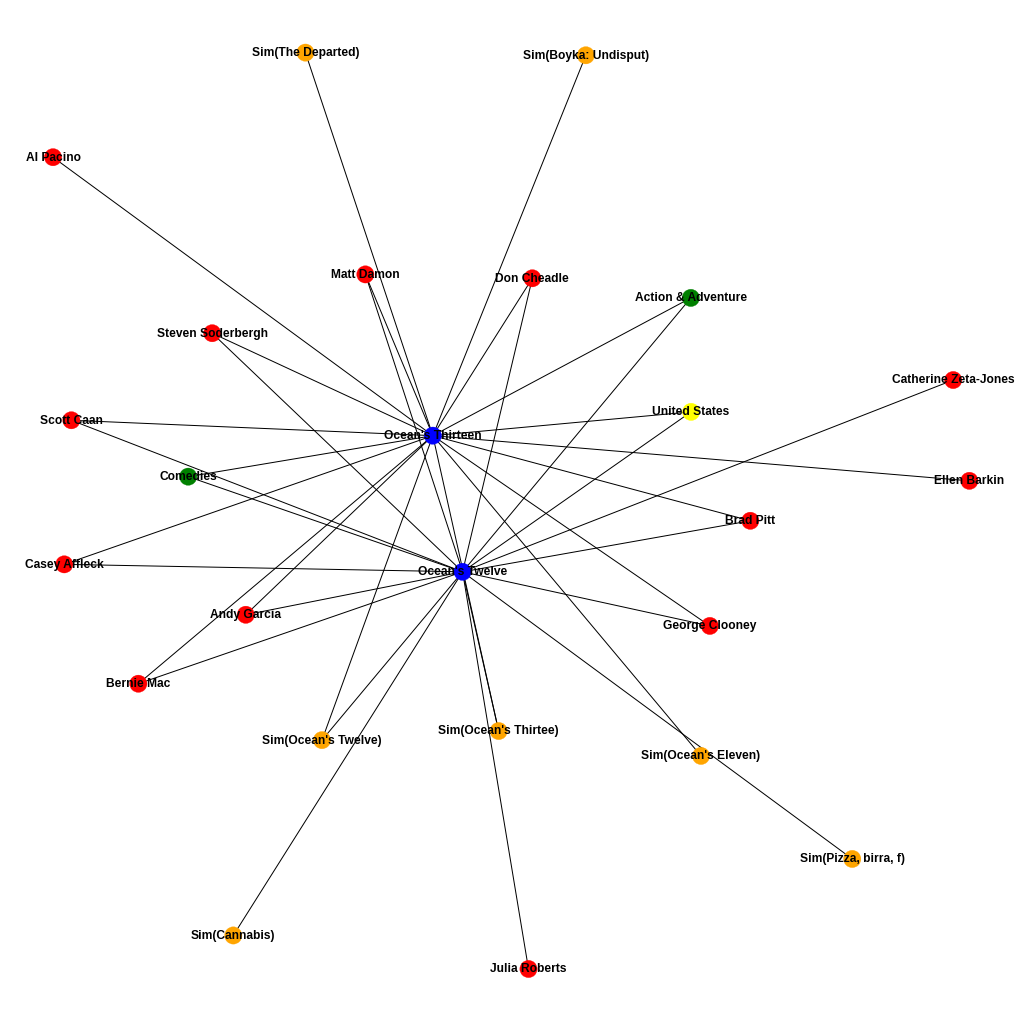

In [41]:
list_in = ["Ocean's Twelve", "Ocean's Thirteen"]

sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

Creating a recommendation function

Exploring neighborhood of target film -> this is a list of actor, director, country, categories

Explore the neighborhood of each neighbor -> Discover the movies that share a node with the target field

Calculate Adamic Adar measure -> final results

In [43]:
def get_recommendation(root):

  commons_dict = {}

  for e in G.neighbors(root):

    for e2 in G.neighbors(e):

      if e2 == root:
        continue
      
      if G.nodes[e2]['label'] == "MOVIE":
        commons = commons_dict.get(e2)

      if commons == None:
        commons_dict.update({e2:[e]})

      else:
        commons.append(e)
        commons_dict.update({e2 : commons})

  movies = []
  weight = []

  for key, values in commons_dict.items():
    w = 0.0
    for e in values:
      w = w + 1/math.log(G.degree(e))

    movies.append(key)
    weight.append(w)


  result = pd.Series(data = np.array(weight), index = movies)
  result.sort_values(inplace = True, ascending = False)
  return result

In [44]:
result = get_recommendation("Ocean's Twelve")
result2 = get_recommendation("Ocean's Thirteen")
result3 = get_recommendation("The Devil Inside")
result4 = get_recommendation("Stranger Things")
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Belmonte'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())


****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
Ocean's Thirteen     7.575565
Ocean's Eleven       1.542593
The Informant!       1.346214
Babel                1.199195
The Mask of Zorro    1.194038
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Ocean's Twelve       7.575565
Ocean's Eleven       2.100704
The Departed         1.698527
Brooklyn's Finest    1.492545
Boyka: Undisputed    1.400020
dtype: float64
****************************************
 Recommendation for 'Belmonte'
****************************************
The Devil and Father Amorth              1.423117
Making a Murderer                        1.243407
Belief: The Possession of Janet Moses    1.116221
The Diabolical                           1.032475
The Autopsy of Jane Doe                  1.032475
dtype: float64
****************************************
 Recommenda

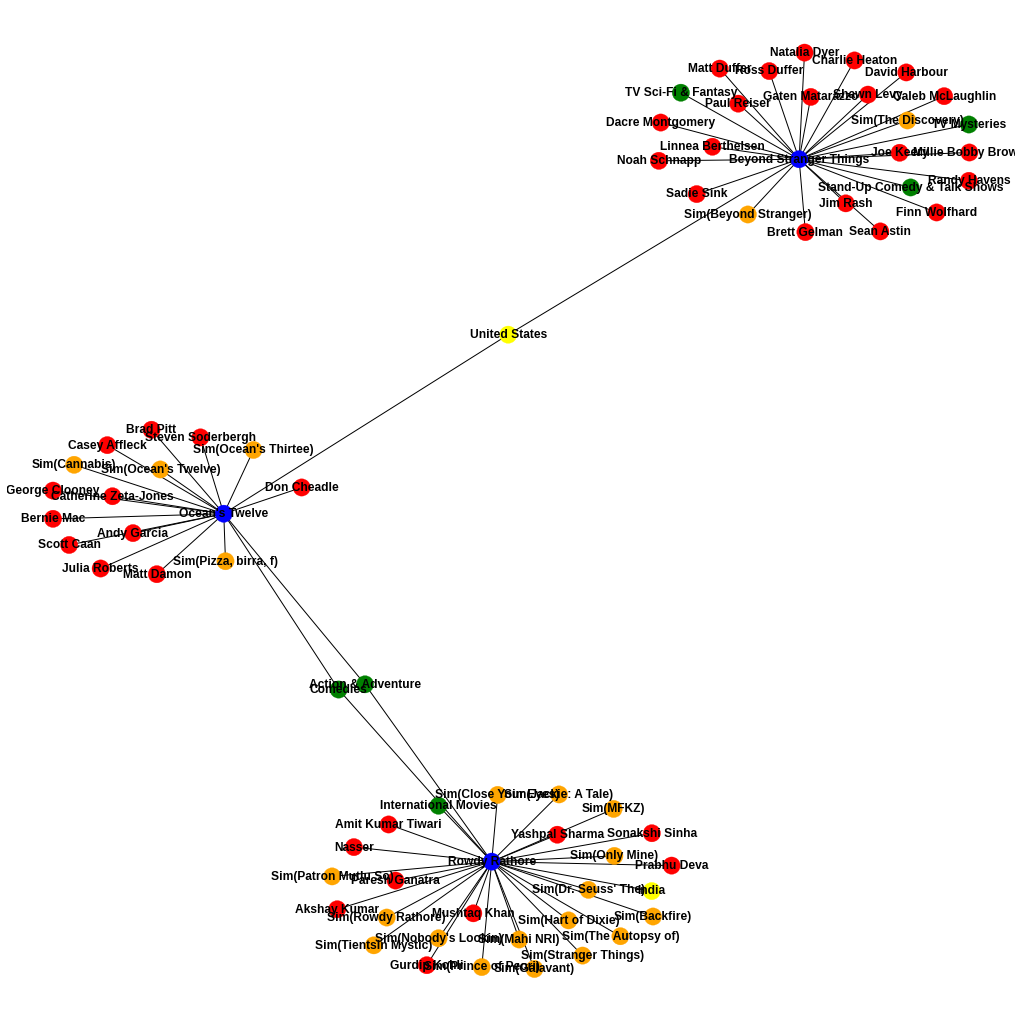

In [50]:
reco=list(result4.index[:2].values)
reco.extend(["Ocean's Twelve"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)